In [3]:
# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType, DateType
from pyspark.sql.functions import col, sum, round, split
from pyspark.sql.functions import udf, max
from pyspark.sql.functions import current_date, to_date, datediff, floor, year
from pyspark.sql import functions as F
from pyspark.sql.functions import count, mean, stddev, min, max, expr, desc
from matplotlib import pyplot as plt
from pyspark.sql.functions import isnan, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# TODO: Create Spark Configuration Object
app_name = "Assignment 2A: Building models to predict future eCommerce sales"
master = "local[*]"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
print('Spark Session created! ')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 12:15:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session created! 


In [4]:
# define each column type for each dataset 
category_schema = StructType([
    StructField("category_id", IntegerType(), True), 
    StructField("cat_level1", IntegerType(), True), 
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True),
])

customer_schema = StructType([
    StructField("row_number", IntegerType(), True),
    StructField("customer_id", IntegerType(), True), 
    StructField("first_name", StringType(), True), 
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", DateType(), True),
    StructField("device_type", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_version", StringType(), True),
    StructField("home_location_lat", DoubleType(), True),
    StructField("home_location_long", DoubleType(), True),
    StructField("home_location", StringType(), True),
    StructField("home_country", StringType(), True),
    StructField("first_join_date", DateType(), True),
])

product_schema = StructType([
    StructField("id", IntegerType(), True), 
    StructField("gender", StringType(), True), 
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", IntegerType(), True)
])


clickstream_schema = StructType([
    StructField("row_number", IntegerType(), True),
    StructField("session_id", StringType(), True), 
    StructField("event_name", StringType(), True), 
    StructField("event_time", StringType(), True),
    StructField("event_id", StringType(), True),
    StructField("traffic_source", StringType(), True),
    StructField("event_metadata", StringType(), True)
])


transaction_schema = StructType([
    StructField("row_number", IntegerType(), True),
    StructField("created_at", TimestampType(), True), 
    StructField("customer_id", IntegerType(), True), 
    StructField("booking_id", IntegerType(), True),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", StringType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", StringType(), True),
    StructField("shipment_location_lat", DoubleType(), True),
    StructField("shipment_location_long", DoubleType(), True),
    StructField("total_amount", DoubleType(), True)
])


customer_session_schema = StructType([
    StructField("row_number", IntegerType(), True), 
    StructField("session_id", StringType(), True), 
    StructField("customer_id", IntegerType(), True)
])

In [5]:
category = spark.read.csv("category.csv", header=True, schema=category_schema)
customer = spark.read.csv("customer.csv", header=True, schema=customer_schema)
product = spark.read.csv("product.csv", header=True, schema=product_schema)
click_stream = spark.read.csv("click_stream.csv", header=True, schema=clickstream_schema)
transaction = spark.read.csv("new_transactions.csv", header=True, schema=transaction_schema)
customer_session = spark.read.csv("customer_session.csv", header=True, schema=customer_session_schema)

print('files loaded and ready to go!')

files loaded and ready to go!


In [6]:
# print schemas
customer_session.printSchema()
customer.printSchema()
category.printSchema()
click_stream.printSchema()
product.printSchema()
transaction.printSchema()

root
 |-- row_number: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- customer_id: integer (nullable = true)

root
 |-- row_number: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- home_location_lat: double (nullable = true)
 |-- home_location_long: double (nullable = true)
 |-- home_location: string (nullable = true)
 |-- home_country: string (nullable = true)
 |-- first_join_date: date (nullable = true)

root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: integer (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = tr

In [ ]:
# Now we need to perform transformations 

In [7]:
# In the clickstream dataset, there are 9 types of events:
# VIEW_PROMO, SCROLL, ADD_PROMO, VIEW_ITEM, CLICK, PURCHASE, ADD_TO_CART, HOMEPAGE, SEARCH
# We categorize them into 3 different categories:
# Category 1(high value actions - highly likely to purchase): ADD_PROMO, ADD_TO_CART
# Category 2(medium value actions - likely to purchase): VIEW_PROMO, VIEW_ITEM, SEARCH
# Category 3(low value actions - just browsing): SCROLL, HOMEPAGE, CLICK

In [9]:
# create conditions for high, medium, and low value actions
high_value_cond = (col('event_name') == 'ADD_PROMO') | (col('event_name') == 'ADD_TO_CART')
med_value_cond = (col('event_name') == 'VIEW_PROMO') | (col('event_name') == 'VIEW_ITEM') | (col('event_name') == 'SEARCH')
low_value_cond = (col('event_name') == 'SCROLL') | (col('event_name') == 'HOMEPAGE') | (col('event_name') == 'CLICK')

# group by session_id and aggregate the counts based on the conditions defined above
feature_df = click_stream.groupBy('session_id').agg(
    sum(high_value_cond.cast('int')).alias('num_cat_highvalue'),
    sum(med_value_cond.cast('int')).alias('num_cat_midvalue'),
    sum(low_value_cond.cast('int')).alias('num_cat_lowvalue')
)

feature_df.show(3)

+--------------------+-----------------+----------------+----------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|
+--------------------+-----------------+----------------+----------------+
|2fdb7762-98d5-432...|                1|               2|               2|
|e7f689a1-28a0-4fe...|                1|               1|               3|
|2faff3e1-25cf-438...|                2|               6|              13|
+--------------------+-----------------+----------------+----------------+
only showing top 3 rows



In [10]:
# total actions for each session
feature_df = feature_df.withColumn('total_actions', 
                                   col('num_cat_highvalue') + col('num_cat_midvalue') + col('num_cat_lowvalue'))

# high value ratio
feature_df = feature_df.withColumn(
    'high_value_ratio', (col('num_cat_highvalue') / col('total_actions') * 100))

# low value ratio
feature_df = feature_df.withColumn(
    'low_value_ratio', (col('num_cat_lowvalue') / col('total_actions') * 100))

# round the ratios 
feature_df = feature_df.withColumn('high_value_ratio', round(col('high_value_ratio'), 2))
feature_df = feature_df.withColumn('low_value_ratio', round(col('low_value_ratio'), 2))


feature_df.show(5)

+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|high_value_ratio|low_value_ratio|
+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+
|2fdb7762-98d5-432...|                1|               2|               2|            5|            20.0|           40.0|
|e7f689a1-28a0-4fe...|                1|               1|               3|            5|            20.0|           60.0|
|2faff3e1-25cf-438...|                2|               6|              13|           21|            9.52|           61.9|
|3f2d99e1-51ff-402...|                1|               0|               2|            3|           33.33|          66.67|
|5386d3f4-98ea-448...|                2|               9|              18|           29|             6.9|          62.07|
+--------------------+--

In [11]:
# define function
def has_promo(event_name):
    if event_name == 'ADD_PROMO':
        return 1
    else:
        return 0

# create UDF
has_promo_udf = udf(has_promo, IntegerType())

# Apply the UDF to column 
click_stream = click_stream.withColumn("is_promotion", has_promo_udf(click_stream["event_name"]))

# group by session_id and find if any event in the session was "ADD_PROMO"
promo_df = click_stream.groupBy('session_id').agg(max('is_promotion').alias('is_promotion'))

# join this information back to feature_df
feature_df = feature_df.join(promo_df, on='session_id', how='left')


feature_df.show(3)

+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|high_value_ratio|low_value_ratio|is_promotion|
+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+------------+
|2faff3e1-25cf-438...|                2|               6|              13|           21|            9.52|           61.9|           1|
|2fdb7762-98d5-432...|                1|               2|               2|            5|            20.0|           40.0|           0|
|3f2d99e1-51ff-402...|                1|               0|               2|            3|           33.33|          66.67|           0|
+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+------------+
only showing top 3 rows



In [12]:
feature_df.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- total_actions: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)



In [13]:
# extract the month from the event_time column 
split_col = split(click_stream['event_time'], '-')
click_stream = click_stream.withColumn('month', split_col.getItem(1))

# define function 
def which_season(month):
    if month in ('12', '01', '02'):
        return 'Winter'
    elif month in ('06', '07', '08'):
        return 'Summer'
    elif month in ('09', '10', '11'):
        return 'Autumn'
    else:
        return 'Spring'

# create UDF
which_season_udf = udf(which_season, StringType())

# apply the UDF to the month column to create a new column "Event_Season"
click_stream = click_stream.withColumn("Event_Season", which_season_udf(col("month")))

# group by session_id and take the maximum occurring season
season_df = click_stream.groupBy('session_id').agg(max('Event_Season').alias('Event_Season'))

# join this information back to feature_df
feature_df = feature_df.join(season_df, on='session_id', how='left')


feature_df.show(2)

+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+------------+------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|total_actions|high_value_ratio|low_value_ratio|is_promotion|Event_Season|
+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+------------+------------+
|2faff3e1-25cf-438...|                2|               6|              13|           21|            9.52|           61.9|           1|      Autumn|
|2fdb7762-98d5-432...|                1|               2|               2|            5|            20.0|           40.0|           0|      Spring|
+--------------------+-----------------+----------------+----------------+-------------+----------------+---------------+------------+------------+
only showing top 2 rows



In [14]:
feature_df.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- total_actions: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- Event_Season: string (nullable = true)



In [15]:
# join customer session with feature_df on session_id
feature_df = feature_df.join(customer_session, on='session_id', how='left')


In [16]:
feature_df = feature_df.join(customer.withColumnRenamed('row_number', 'customer_row_number')
                                      .withColumnRenamed('customer_id', 'customer_customer_id'),
                             on=col('customer_id') == col('customer_customer_id'), how='left')

In [17]:
feature_df = feature_df.withColumn('age', floor(datediff(current_date(), to_date(col('birthdate'), 'yyyy-MM-dd'))/365.25))


In [18]:
# extract the year from the eventtime column
feature_df = feature_df.withColumn('year', year(to_date(col('first_join_date'), 'yyyy-MM-dd')))

# cast age and year columns to int type
feature_df = feature_df.withColumn("age", col("age").cast('int'))
feature_df = feature_df.withColumn("year", col("year").cast('int'))

In [19]:
feature_df.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- total_actions: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- Event_Season: string (nullable = true)
 |-- row_number: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- customer_row_number: integer (nullable = true)
 |-- customer_customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- home_location_lat: doub

In [20]:
feature_df = feature_df.select('customer_id','session_id','num_cat_highvalue','num_cat_midvalue','num_cat_lowvalue',
 'low_value_ratio','high_value_ratio','is_promotion','Event_Season',
                               'gender','home_location','device_type','age','year')

In [21]:
feature_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- Event_Season: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- year: integer (nullable = true)



In [22]:
# we cant just look at if a customer_id is in the transaction table as the payment might be invalid.
# we can only count a purchase if the payment is a success because that is what defines a purchase.
# join transaction on session_id
feature_df_with_purchase = feature_df.join(transaction, on='session_id', how='left_outer')

In [23]:
# A user either makes the purchase = Success 
# Does not make the Purchase = null 
# or fails to make a purchase = failed
feature_df_with_purchase.select('payment_status').distinct().show()

+--------------+
|payment_status|
+--------------+
|          null|
|       Success|
|          Fail|
+--------------+



In [24]:
# transformations of gender
def purchase_made(s):
    if s == 'Success':
        return 1
    else:
        return 0

# Step 2: Create a UDF
purchase_made_udf = udf(purchase_made, IntegerType())

# Step 3: Apply the UDF to the desired column
feature_df_with_purchase = feature_df_with_purchase.withColumn("payment_status", purchase_made_udf(feature_df_with_purchase["payment_status"]))

feature_df_with_purchase.select('payment_status').distinct().show()

+--------------+
|payment_status|
+--------------+
|             1|
|             0|
+--------------+



In [25]:
feature_df_with_purchase.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- Event_Season: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- row_number: integer (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- booking_id: integer (nullable = true)
 |-- product_metadata: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- payment_status: integer (nullable = true)
 |-- promo_amount: string (nullable = true)
 |-- promo_code: string (nu

In [26]:
# rename the payment_status to label 
feature_df_with_purchase = feature_df_with_purchase.withColumnRenamed("payment_status","label")

In [27]:
feature_df_with_purchase.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- Event_Season: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- row_number: integer (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- booking_id: integer (nullable = true)
 |-- product_metadata: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- promo_amount: string (nullable = true)
 |-- promo_code: string (nullable = 

In [ ]:
# now we do some EDA

In [28]:
# list of numeric columns
numeric_columns = ["num_cat_highvalue", "num_cat_midvalue", "num_cat_lowvalue", 
                   "low_value_ratio", "high_value_ratio"]
feature_df_with_purchase.select(numeric_columns).summary().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+
|summary|num_cat_highvalue|  num_cat_midvalue|  num_cat_lowvalue|   low_value_ratio| high_value_ratio|
+-------+-----------------+------------------+------------------+------------------+-----------------+
|  count|           895203|            895203|            895203|            895203|           895203|
|   mean|2.528691257737072|3.4278180479734766|7.4270696143779675| 52.46481924211479|26.12244419422314|
| stddev| 2.29995610601219| 4.475989272102889| 9.239566040509843|16.545809924504603|17.57811167783582|
|    min|                0|                 0|                 1|              1.82|              0.0|
|    25%|                1|                 1|                 2|              40.0|             12.5|
|    50%|                2|                 2|                 5|             52.94|             25.0|
|    75%|                3|                 5|                 9|        

In [29]:
feature_df_with_purchase.select('age','year').summary().show()

+-------+------------------+------------------+
|summary|               age|              year|
+-------+------------------+------------------+
|  count|            852582|            852582|
|   mean|27.267948420210608| 2018.674827758503|
| stddev|  7.28509480115457|1.6759156622858058|
|    min|                 7|              2016|
|    25%|                22|              2017|
|    50%|                27|              2019|
|    75%|                32|              2020|
|    max|                69|              2022|
+-------+------------------+------------------+



In [30]:
# list of Category columns
non_numeric_columns = ["session_id", "Event_Season", "gender", "home_location", "device_type"]

for col_name in non_numeric_columns:
    feature_df_with_purchase.groupBy(col_name).count().orderBy(col('count').desc()).show(5)

+--------------------+-----+
|          session_id|count|
+--------------------+-----+
|00008762-b685-4f9...|    1|
|000593e4-535e-43f...|    1|
|00005746-17ec-449...|    1|
|0008e4fe-a620-4f9...|    1|
|00003eca-954b-415...|    1|
+--------------------+-----+
only showing top 5 rows



+------------+------+
|Event_Season| count|
+------------+------+
|      Summer|253699|
|      Winter|243099|
|      Spring|219240|
|      Autumn|179165|
+------------+------+



+------+------+
|gender| count|
+------+------+
|     F|543509|
|     M|309073|
|  null| 42621|
+------+------+



+-------------+------+
|home_location| count|
+-------------+------+
| Jakarta Raya|156698|
|   Jawa Barat|101244|
|  Jawa Tengah| 95240|
|   Jawa Timur| 81106|
|   Yogyakarta| 66444|
+-------------+------+
only showing top 5 rows



+-----------+------+
|device_type| count|
+-----------+------+
|    Android|656809|
|        iOS|195773|
|       null| 42621|
+-----------+------+



In [31]:
# list of binary columns
boolean_columns = ["is_promotion", "label"]

for col_name in boolean_columns:
    feature_df_with_purchase.groupBy(col_name).count().show()

+------------+------+
|is_promotion| count|
+------------+------+
|           1|326535|
|           0|568668|
+------------+------+



+-----+------+
|label| count|
+-----+------+
|    1|527812|
|    0|367391|
+-----+------+



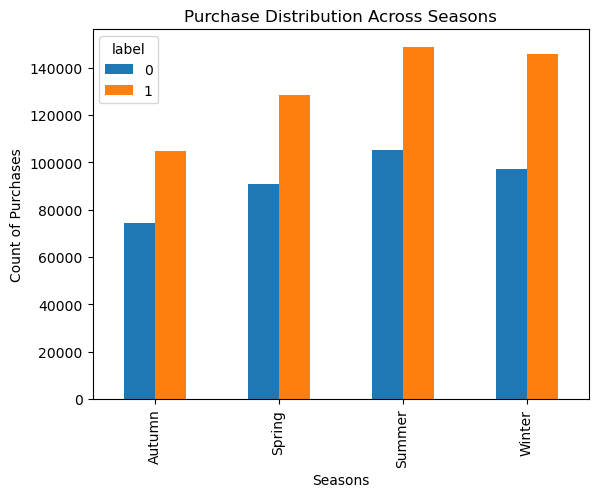

In [32]:
season_purchase_df = feature_df_with_purchase.groupBy("Event_Season", "label").count().toPandas()

#bar plot
season_purchase_df.pivot(index='Event_Season', columns='label', values='count').plot(kind='bar')

plt.title('Purchase Distribution Across Seasons')
plt.xlabel('Seasons')
plt.ylabel('Count of Purchases')

plt.show()

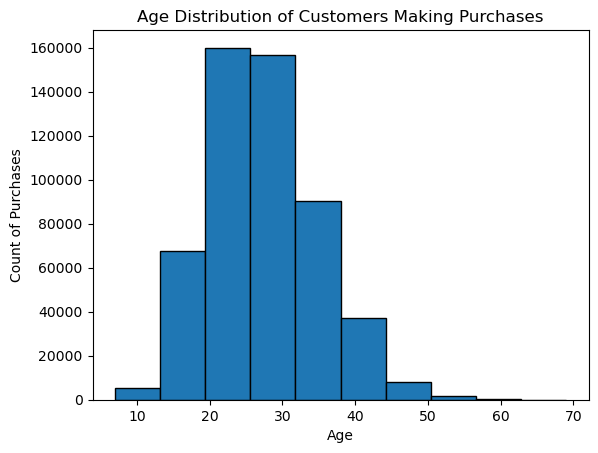

In [33]:
age_purchase_df = feature_df_with_purchase.filter("label = 1").select("age").toPandas()

# histogram
plt.hist(age_purchase_df['age'], bins=10, edgecolor='black')

plt.title('Age Distribution of Customers Making Purchases')
plt.xlabel('Age')
plt.ylabel('Count of Purchases')

plt.show()

In [34]:
#Deciding on which features could be selcted 

# Event_Season: certain product may only be needed in the winter.

# home_location: Geographical factors can have an impact as different regions might have varied consumer behaviour for economic reasons.

# gender: if product is gender-specific it can have an impact

# age: can have a large impact on whether someone purchases as the amount of money someone has is strongly link to their age and interests over time.

# year: can have an impact where large economic and environmental changes happened such as COVID which may lead to more or less of buying a certain product or service.

# device_type: It maybe that because iphones are more expensive meanly tey are more likly to buy or that the phones are less likely to crash.

# payment_method: maybe certain payment methods are more prone to fail or maybe people who try to buy without having enough funds use a simular payment method.

# shipment_fee: maybe people dont see the shiping fee cost and the payment fails and then decide aganist buyign the product.

# is_promotion: promstion may increase the likelihood someone will buy as its on sale.

# total_amount: maybe people dont know how much they have in their account and thus the purchase fails and maybe this is more common in more expensive products.

# num_cat_highvalue, num_cat_midvalue, num_cat_lowvalue: Customers purchasing high-value items might be different demographically than those purchasing low-value items.

# low_value_ratio, high_value_ratio: These ratios offer a normalised perspective of the customer's purchasing preference.

# Event_Season, home_location and payment_method we can use StringIndexer and OneHotEncoder. device_type and gender we can make binary

In [38]:
feature_df_with_purchase = feature_df_with_purchase.select('Event_Season', 'home_location', 
                                                           'gender', 'num_cat_highvalue', 
                                                           'num_cat_midvalue', 'num_cat_lowvalue',
                                                           'low_value_ratio', 'high_value_ratio', 
                                                           'is_promotion', 'age', 'year','label',
                                                           'shipment_fee','total_amount','payment_method','device_type')

In [39]:
feature_df_with_purchase = feature_df_with_purchase.withColumn("num_cat_highvalue",feature_df_with_purchase.num_cat_highvalue.cast('int'))
feature_df_with_purchase = feature_df_with_purchase.withColumn("num_cat_midvalue",feature_df_with_purchase.num_cat_midvalue.cast('int'))
feature_df_with_purchase = feature_df_with_purchase.withColumn("num_cat_lowvalue",feature_df_with_purchase.num_cat_lowvalue.cast('int'))
feature_df_with_purchase = feature_df_with_purchase.withColumn("low_value_ratio",feature_df_with_purchase.low_value_ratio.cast('double'))
feature_df_with_purchase = feature_df_with_purchase.withColumn("high_value_ratio",feature_df_with_purchase.high_value_ratio.cast('double'))
feature_df_with_purchase = feature_df_with_purchase.withColumn("shipment_fee",feature_df_with_purchase.shipment_fee.cast('int'))

In [40]:
feature_df_with_purchase.printSchema()

root
 |-- Event_Season: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- num_cat_highvalue: integer (nullable = true)
 |-- num_cat_midvalue: integer (nullable = true)
 |-- num_cat_lowvalue: integer (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- shipment_fee: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- device_type: string (nullable = true)



In [41]:
# transformations of gender
def M_or_F(s):
    if s == 'M':
        return 1
    elif s == 'F':
        return 0
    else:
        return None

# Create a UDF
M_or_F_udf = udf(M_or_F, IntegerType())

# Apply the UDF to the desired column
feature_df_with_purchase = feature_df_with_purchase.withColumn("gender", M_or_F_udf(feature_df_with_purchase["gender"]))

feature_df_with_purchase.select('gender').distinct().show()

+------+
|gender|
+------+
|  null|
|     1|
|     0|
+------+



In [42]:
# transformation of device 
def apple_or_android(s):
    if s == 'iOS':
        return 1
    elif s == 'Android':
        return 0
    else:
        return None

# Create a UDF
apple_or_android_udf = udf(apple_or_android, IntegerType())

# Apply the UDF to the desired column
feature_df_with_purchase = feature_df_with_purchase.withColumn("device_type", apple_or_android_udf(feature_df_with_purchase["device_type"]))

feature_df_with_purchase.select('device_type').distinct().show()

+-----------+
|device_type|
+-----------+
|       null|
|          1|
|          0|
+-----------+



In [43]:
# Show the null value data
feature_df_with_purchase.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in feature_df_with_purchase.columns]).show()

+------------+-------------+------+-----------------+----------------+----------------+---------------+----------------+------------+-----+-----+-----+------------+------------+--------------+-----------+
|Event_Season|home_location|gender|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|low_value_ratio|high_value_ratio|is_promotion|  age| year|label|shipment_fee|total_amount|payment_method|device_type|
+------------+-------------+------+-----------------+----------------+----------------+---------------+----------------+------------+-----+-----+-----+------------+------------+--------------+-----------+
|           0|        42621| 42621|                0|               0|               0|              0|               0|           0|42621|42621|    0|       42621|       42621|         42621|      42621|
+------------+-------------+------+-----------------+----------------+----------------+---------------+----------------+------------+-----+-----+-----+------------+------------+---

In [44]:
# clear all rows with any null values
feature_df_with_purchase = feature_df_with_purchase.dropna(how = 'any')

In [45]:
boolean_columns = ["label"]

for col_name in boolean_columns:
    feature_df_with_purchase.groupBy(col_name).count().show()

+-----+------+
|label| count|
+-----+------+
|    1|527812|
|    0|324770|
+-----+------+



In [46]:
# issue with the K-means model needed to be repartitioned 
feature_df_with_purchase = feature_df_with_purchase.repartition(15)  

In [47]:
feature_df_with_purchase.printSchema()

root
 |-- Event_Season: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- num_cat_highvalue: integer (nullable = true)
 |-- num_cat_midvalue: integer (nullable = true)
 |-- num_cat_lowvalue: integer (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- shipment_fee: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- device_type: integer (nullable = true)



In [48]:
# Preparing Spark ML Transformers/Estimators for features, labels, and models ¶

In [49]:
# stringindex all the category variables
indexer = StringIndexer(inputCols=['Event_Season', 'home_location','payment_method'], 
                        outputCols=['Event_Season_index', 'home_location_index','payment_method_index'])

indexer

StringIndexer_693d8bfad2e5

In [50]:
# now we need to use the OneHotEncoder
encoder = OneHotEncoder(inputCols=['Event_Season_index', 'home_location_index','payment_method_index'], 
                        outputCols=['Event_Season_vec', 'home_location_vec','payment_method_vec'])

encoder

OneHotEncoder_5a719747476d

In [51]:
# now we need to use the VectorAssembler to bring it all together 
assembler = VectorAssembler(
    inputCols=[
        'Event_Season_vec', 
        'home_location_vec',
        'payment_method_vec',
        'gender',  
        'age', 
        'year',
        'is_promotion', 
        'shipment_fee',
        'device_type',
        'total_amount',        
        
    ],
    outputCol='features'
)

assembler

VectorAssembler_8947ef9edb77

In [53]:
# create the Random Forest model Estimator
rf_estimator = RandomForestClassifier()

# create the Gradient-Boosted Tree model Estimator
gbt_estimator = GBTClassifier()

In [54]:
# create pipeline for Random Forest model
rf_pipeline = Pipeline(stages=[
    indexer,
    encoder,
    assembler,
    rf_estimator
])

# create pipeline for Gradient-Boosted model
gbt_pipeline = Pipeline(stages=[
    indexer,
    encoder,
    assembler,
    gbt_estimator
])

print("Random Forest pipeline:", rf_pipeline)
print("Gradient-Boosted Tree pipeline:", gbt_pipeline)

Random Forest pipeline: Pipeline_56ed8284ccdc
Gradient-Boosted Tree pipeline: Pipeline_8e318f1dfbd2


In [55]:
# slipt data into 80% training and 20% testing
sampled_df = feature_df_with_purchase.sample(False, 0.2, seed=1)

In [56]:
train_data, test_data = sampled_df.randomSplit([0.8, 0.2], seed=11)

In [57]:
sampled_df.cache()

DataFrame[Event_Season: string, home_location: string, gender: int, num_cat_highvalue: int, num_cat_midvalue: int, num_cat_lowvalue: int, low_value_ratio: double, high_value_ratio: double, is_promotion: int, age: int, year: int, label: int, shipment_fee: int, total_amount: double, payment_method: string, device_type: int]

In [58]:
# Training and evaluating models

In [59]:
# Train the Random Forest model
rf_model = rf_pipeline.fit(train_data)

# Train the Gradient-Boosted Tree model
gbt_model = gbt_pipeline.fit(train_data)

# Make predictions on the testing data
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

In [60]:
# evaluate the models
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
gbt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

rf_auc = rf_evaluator.evaluate(rf_predictions)
gbt_auc = gbt_evaluator.evaluate(gbt_predictions)

# AUC scores
print("Random Forest AUC:", rf_auc)
print("Gradient-Boosted Tree AUC:", gbt_auc)

Random Forest AUC: 0.7863673814427478
Gradient-Boosted Tree AUC: 0.8012628706030079


In [61]:
def confusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    return TP,TN,FP,FN


rf_metrics = confusion_matrix(rf_predictions)
gbt_metrics = confusion_matrix(gbt_predictions)

rf_metrics, gbt_metrics

((20166, 6546, 6480, 1149), (20151, 6555, 6471, 1164))

In [62]:
def compute_metrics(predictions):
    # Calculate elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    
    # calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0  # handle division by zero
    recall = TP / (TP + FN) if TP + FN != 0 else 0    # handle division by zero
    
    return accuracy, precision, recall

In [63]:
rfp = rf_predictions.select("label", "prediction")
gbt = gbt_predictions.select("label", "prediction")

# apply the function
gbt_m = compute_metrics(gbt)
rfp_m = compute_metrics(rfp)

# convert to list 
gbt_m = list(gbt_m)
rfp_m = list(rfp_m)


print(f'The GBT Accuracy is: {gbt_m[0]}, Percision: {gbt_m[1]} and recall is {gbt_m[2]}')
print(f'The RF Accuracy is: {rfp_m[0]}, Percision: {rfp_m[1]} and recall is {rfp_m[2]}')

The GBT Accuracy is: 0.7776710055036254, Percision: 0.7569303583502367 and recall is 0.9453905700211119
The RF Accuracy is: 0.7778457237704202, Percision: 0.7568115289349245 and recall is 0.946094299788881


In [66]:
#User Defined Function to split the probabilities into two columns
import pyspark.sql.functions as F
import pyspark.sql.types as T
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

In [67]:
df = gbt_predictions.withColumn('probability', to_array('probability'))

In [68]:
#A new df which contains the probabilites in separate columns
prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'label')

In [69]:
#for threshold 0.7, lets calculate the TN,TP,FN,FP from confusion matrix
threshold=0.7
test_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
tp,tn,fp,fn = confusion_matrix(prob_df)  
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
print('TPR:',tpr,'FPR:',fpr)

TPR: 0.9453905700211119 FPR: 0.49677567941040995


In [70]:
dfrf = rf_predictions.withColumn('probability', to_array('probability'))
prob_dfrf = dfrf.select(dfrf.probability[0].alias('negative_prob'),dfrf.probability[1].alias('positive_prob'),'label')
prob_dfrf.withColumn('prediction',F.when(prob_dfrf.positive_prob > threshold,1).otherwise(0))

# this fucntion loops through all the thresholds and computes the TPR and TFR 
#for each threshold. 
def tpr_fpr(prob_df):
    # TPR and TFR values in separate arrays
    
    tpr_fpr = []
    
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    for threshold in thresholds:
        test_df = prob_df.withColumn('prediction', F.when(prob_df.positive_prob > threshold, 1).otherwise(0))
        tp, tn, fp, fn = confusion_matrix(test_df)  
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_fpr.append((threshold, tpr, fpr))  
        
    return tpr_fpr

# prob_df = gtboost
# prob_dfrf = random forest 
gbt_tpr_fpr = tpr_fpr(prob_df)
random_forest_tpr_fpr = tpr_fpr(prob_dfrf)

print(gbt_tpr_fpr)
print('---------------')
print(random_forest_tpr_fpr)

[(0.1, 0.998639455782313, 0.9705972670044526), (0.2, 0.9470326061459067, 0.5040687855059113), (0.3, 0.946094299788881, 0.49769691386457854), (0.4, 0.946094299788881, 0.49746660525103636), (0.5, 0.9453905700211119, 0.49677567941040995), (0.6, 0.9384471029791227, 0.4899431905419929), (0.7, 0.5342247243725077, 0.14593889144787348), (0.8, 0.36378137461881305, 0.062106556118532164), (0.9, 0.050199390100867936, 0.008751727314601566), (1.0, 0.0, 0.0)]
---------------
[(0.1, 1.0, 1.0), (0.2, 1.0, 1.0), (0.3, 1.0, 1.0), (0.4, 0.9551958714520291, 0.5907415937356058), (0.5, 0.946094299788881, 0.49746660525103636), (0.6, 0.9441238564391273, 0.4960847535697835), (0.7, 0.36091954022988504, 0.059957009058805466), (0.8, 0.0, 0.0), (0.9, 0.0, 0.0), (1.0, 0.0, 0.0)]


In [71]:
#Save the Gradient-Boosted Tree model 
gbt_model_path = "./gbt_model_new11"
gbt_model.write().overwrite().save(gbt_model_path)

In [72]:
# Customer Segmentation and Knowledge sharing with K-Mean

In [73]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# stringindex all the category variables
indexer = StringIndexer(inputCols=['Event_Season', 'home_location'], 
                        outputCols=['Event_Season_index', 'home_location_index'])

indexer

StringIndexer_ad329ba2f3a1

In [74]:
# now we need to use the OneHotEncoder
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCols=['Event_Season_index', 'home_location_index'], 
                        outputCols=['Event_Season_vec', 'home_location_vec'])

encoder

OneHotEncoder_85259d14ba8b

In [75]:
assembler = VectorAssembler(
    inputCols=[
        'Event_Season_vec',
        'home_location_vec',
        'gender',
        'age', 
        'device_type',
        'total_amount',
    ],
    outputCol='features'
)
assembler

VectorAssembler_9ba9ebd0126c

In [76]:
# StandardScaler to scale the assembled features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=True
)


In [77]:
#Define the K-Means estimator with number of clusters =2
#Create a KMeans Model Estimator initialized with 2 clusters
k_means = KMeans(featuresCol='features', k=2)

In [78]:
# Creating the pipeline
pipeline = Pipeline(stages=[
    indexer, 
    encoder, 
    assembler, 
    scaler, 
    k_means
])

In [79]:
# Fitting the pipeline to the original data
model = pipeline.fit(sampled_df)

# Transforming the data through the pipeline
predictions = model.transform(sampled_df)

In [80]:
predictions.select('features','prediction','scaledFeatures').show(3)

+--------------------+----------+--------------------+
|            features|prediction|      scaledFeatures|
+--------------------+----------+--------------------+
|(39,[0,9,36,38],[...|         0|[1.59403970784341...|
|(39,[2,3,36,38],[...|         1|[-0.6273332679045...|
|(39,[1,3,36,38],[...|         1|[-0.6273332679045...|
+--------------------+----------+--------------------+
only showing top 3 rows



In [81]:
#Display the number of instances grouped by cluster
# # # Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

In [82]:
#Calculate the Silhouette Score for the Pipeline Model
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5184397246574902


Silhouette with squared euclidean distance for k=2 is 0.5078013077040943


Silhouette with squared euclidean distance for k=3 is 0.5886153742910105


Silhouette with squared euclidean distance for k=4 is 0.48174826288017963
Silhouette with squared euclidean distance for k=5 is 0.4687398236097412


Silhouette with squared euclidean distance for k=6 is 0.4523481025378426
Silhouette with squared euclidean distance for k=7 is 0.45285241506774887


Silhouette with squared euclidean distance for k=8 is 0.43668241855629075


Silhouette with squared euclidean distance for k=9 is 0.43717406881362475
Silhouette with squared euclidean distance for k=10 is 0.4367839972956869


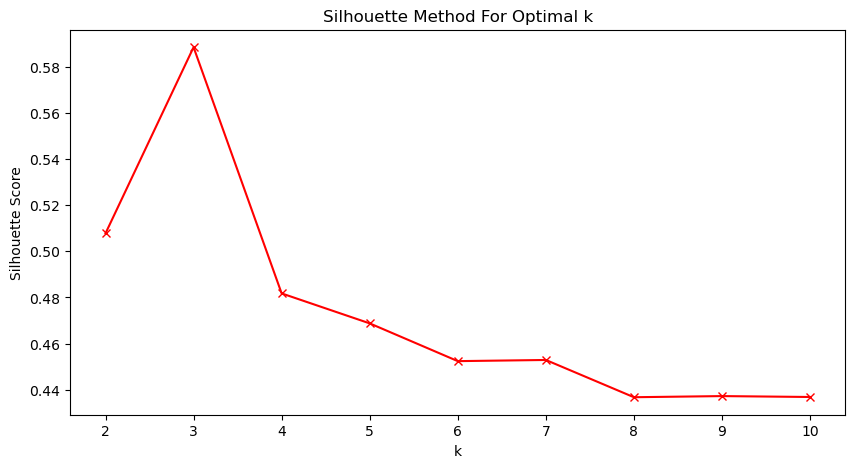

In [83]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

k_values = list(range(2, 11)) 
silhouette_list = []
for k in k_values:
    k_means = KMeans().setK(k).setSeed(1)
    
    updated_pipeline = Pipeline(stages=[
        indexer, 
        encoder, 
        assembler, 
        scaler, 
        k_means
    ])
    
# fitting and transforming
    updated_model = updated_pipeline.fit(sampled_df)
    predictions = updated_model.transform(sampled_df)
    
# silhouette score 
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    print(f"Silhouette with squared euclidean distance for k={k} is {silhouette}")

    
    
    
# plot
plt.figure(figsize=(10,5))
plt.plot(k_values, silhouette_list, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

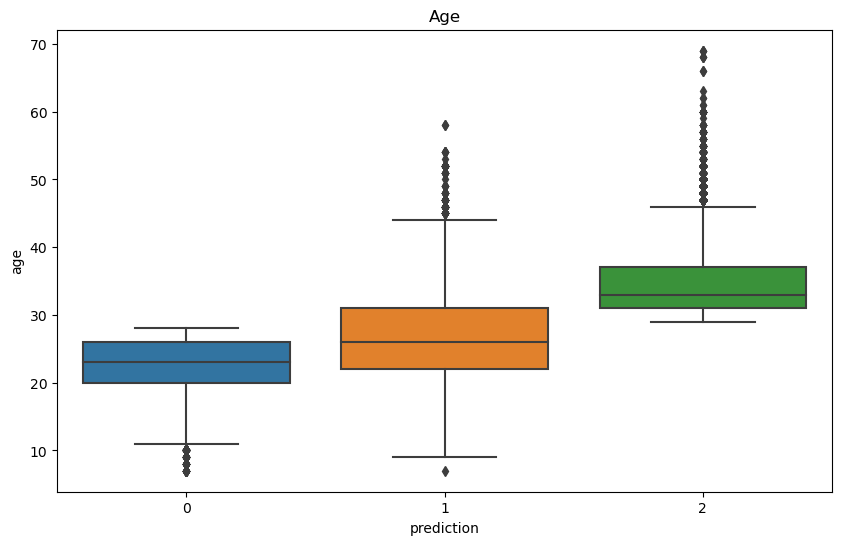

In [84]:
# use the optimal number of clusters for plotting 
optimal_k = 3
k_means_optimal = KMeans().setK(optimal_k).setSeed(1)

# Building a new pipeline with the optimal KMeans model
optimal_pipeline = Pipeline(stages=[
    indexer, 
    encoder, 
    assembler, 
    scaler, 
    k_means_optimal
])

# fitting and transforming the 3 clusters 
optimal_model = optimal_pipeline.fit(sampled_df)
predictions_optimal = optimal_model.transform(sampled_df)

# convert to pandas 
predictions_pd = predictions_optimal.toPandas()

# age plot
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(x='prediction', y='age', data=predictions_pd)
plt.title('Age')
plt.show()

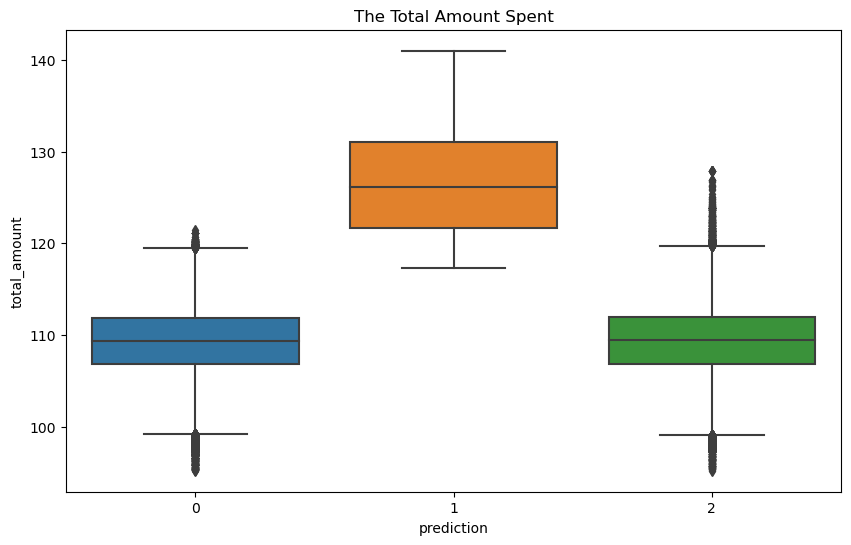

In [85]:
# total amount plot
plt.figure(figsize=(10,6))
sns.boxplot(x='prediction', y='total_amount', data=predictions_pd)
plt.title('The Total Amount Spent')
plt.show()

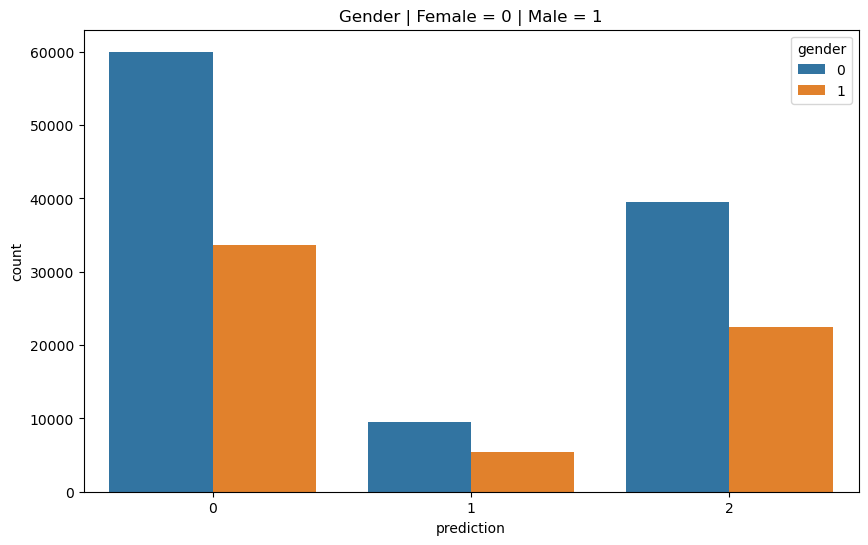

In [86]:
# gender plot
plt.figure(figsize=(10,6))
sns.countplot(x='prediction', hue='gender', data=predictions_pd)
plt.title('Gender | Female = 0 | Male = 1')
plt.show()

Using K-means clustering algorithm to segment the customers based on these features:

Home location
Device type
Age
Gender
Season
this resulted in the optimal number of clusters was K = 3.

Cluster 1: These customers are mostly female who have the age of around mid 30's in most cases and are considered average spenders in terms of average amount spent for each purchase.

Cluster 2: These customers have a slightly younger median age which sits around 26-27 but have a much larger distribution in terms of variance. Theses cusotmers are our biggest spenders in terms of total amount with a median of 125, however are much less common and are slightly more likely to be female.

Cluster 3: These customers are our youngest with all being under 30 and most are mid to early 20's. These cusotmers are overwhelmingly female almost double and spend around the same as cluster 1 with a median of around 108 for total amount per purchase.

Based on theses different kinds of cusomters the business can tailor targetd adds to these groups or use this infomation in other was to increase profits.